Question 14

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self, input_chan, kernel, strd, padding, output):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_chan, 16, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        # self.avgpool = nn.AvgPool2d((4,4), stride=None, padding=0)
        # self.maxpool = nn.MaxPool2d((4,4), stride=None, padding=0)
        self.out = nn.Linear(64, output)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # print(x.shape)
        x = x.mean(dim=(-2, -1)) #dit werkt wel -> equivalent van glob average pool?
        # glob_average_pooling=nn.AvgPool2d((x.shape[2],x.shape[3]), stride=None, padding=0) #dit werkt niet
        # x = glob_average_pooling(x)
        # glob_max_pooling=nn.MaxPool2d((x.shape[2],x.shape[3]), stride=None, padding=0) #dit werkt niet
        # x = glob_average_pooling(x)
        # print(x.shape)
        output = self.out(x)
        return output

In [5]:
def validate(net, loader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader['val_set']:
            output = net(x)
            _,pred_y = torch.max(output, dim = 1)
            correct += (pred_y == y).float().sum()

    print('accuracy on validation set', (correct / 10000)*100, '%')
    return (correct / 10000)*100

def train(net, loader, epochs, loss_f, opt):
    train_loss = []
    epoch_list = []
    acc_list = []

    for i in range(epochs):
        print('epoch = ', i)
        for j, (x, y) in enumerate(loader['train_set']):
            opt.zero_grad()
            x_batch = x
            y_batch = y
            output = net.forward(x_batch)
            loss = loss_f(output, y_batch)
            train_loss.append(loss)
            if j % 1000 == 0:
                print('loss:', loss.item())
            loss.backward()
            opt.step() 
        epoch_list.append(i)
        acc_list.append(validate(net, loader))
    return [train_loss, epoch_list, acc_list]

def loader_loop(loader_list, epochs, input_chan, kernel, stride, padding, output):
    results = []
    lr = 0.0001
    for loader in loader_list:
        net = Net(input_chan, kernel, stride, padding, output)
        loss_f = nn.CrossEntropyLoss()
        opt = optim.Adam(net.parameters(), lr)
        result = train(net, loader, epochs, loss_f, opt)
        results.append(result)
        print('---next image set---')
    return results

def image_folder(path):
    training_data = torchvision.datasets.ImageFolder(path+'mnist-varres/train/', transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))
    test_set= torchvision.datasets.ImageFolder(path+'mnist-varres/test/', transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))
    trainsize = round(0.8*len(training_data))
    train_set, val_set = torch.utils.data.random_split(training_data, [trainsize, len(training_data)-trainsize]) 
    return [train_set, val_set, test_set]

def get_data(path1, path2, path3):
    data1 = image_folder(path1)
    data2 = image_folder(path2)
    data3 = image_folder(path3)
    return data1, data2, data3

def get_loaders(batch_size, train_set, val_set, test_set):
    loaders = {'train_set' : DataLoader(train_set, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
               'val_set' : DataLoader(val_set, 
                                          batch_size=len(val_set), 
                                          shuffle=True, 
                                          num_workers=1),
                'test_set'  : DataLoader(test_set, 
                                          batch_size=len(test_set), 
                                          shuffle=False, 
                                          num_workers=1)}
    return loaders

In [6]:
path1 = '32x32/'
path2 = '48x48/'
path3 = '64x64/'
data32, data48, data64 = get_data(path1, path2, path3)

batch_size = 64
loaders32 = get_loaders(batch_size, data32[0], data32[1], data32[2])
loaders48 = get_loaders(batch_size, data48[0], data48[1], data48[2])
loaders64 = get_loaders(batch_size, data64[0], data64[1], data64[2])
loader_list = [loaders32, loaders48, loaders64]

In [7]:
input_chan = 1
output = 10
kernel = 3
stride = 1
padding = 1
epochs = 5
results = loader_loop(loader_list, epochs, input_chan, kernel, stride, padding, output)

{'train_set': <torch.utils.data.dataloader.DataLoader object at 0x108b0b340>, 'val_set': <torch.utils.data.dataloader.DataLoader object at 0x108b0b4f0>, 'test_set': <torch.utils.data.dataloader.DataLoader object at 0x108b0b310>}
epoch =  0
loss: 2.3140907287597656
accuracy on validation set tensor(10.7200) %
epoch =  1
loss: 2.2188496589660645
accuracy on validation set tensor(14.7800) %
epoch =  2
loss: 1.9946706295013428
accuracy on validation set tensor(18.3400) %
epoch =  3
loss: 1.7059462070465088
accuracy on validation set tensor(22.5000) %
epoch =  4
loss: 1.6503911018371582
accuracy on validation set tensor(24.7100) %
---next image set---
{'train_set': <torch.utils.data.dataloader.DataLoader object at 0x108ac4be0>, 'val_set': <torch.utils.data.dataloader.DataLoader object at 0x108b0bc70>, 'test_set': <torch.utils.data.dataloader.DataLoader object at 0x108b0bac0>}
epoch =  0
loss: 2.2948849201202393
accuracy on validation set tensor(4.6600) %
epoch =  1
loss: 2.283815383911133
a

<function matplotlib.pyplot.show(*args, **kw)>

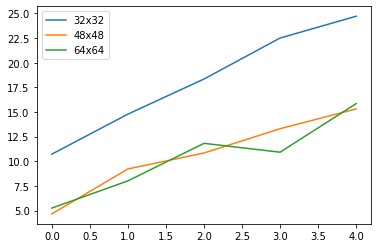

In [9]:
y1 = results[0][2]
x1 = results[0][1]
plt.plot(x1, y1, label = '32x32')
y2 = results[1][2]
x2 = results[1][1]
plt.plot(x2, y2, label = '48x48')
y3 = results[2][2]
x3 = results[2][1]
plt.plot(x3, y3, label = '64x64')
plt.legend(loc='best')
plt.savefig('figures/q14')
plt.show

Question 15

Question 16: compare global avg and max pool

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self, input_chan, kernel, strd, padding, output, avg=False):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_chan, 16, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, kernel, strd, padding), nn.ReLU(), nn.MaxPool2d(2,2))
        # self.avgpool = nn.AvgPool2d((4,4), stride=None, padding=0)
        # self.maxpool = nn.MaxPool2d((4,4), stride=None, padding=0)
        self.out = nn.Linear(64, output)
        self.avg = avg

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # print(x.shape)
        if self.avg==True:
            x = x.mean(dim=(-2, -1)) #dit werkt wel -> equivalent van glob average pool?
        # glob_average_pooling=nn.AvgPool2d((x.shape[2],x.shape[3]), stride=None, padding=0) #dit werkt niet
        # x = glob_average_pooling(x)
        else:
            glob_average_pooling=nn.MaxPool2d((x.shape[2],x.shape[3]), stride=None, padding=0) #dit werkt niet
            x = glob_average_pooling(x)
        # print(x.shape)
        output = self.out(x)
        return output

In [ ]:
def validate(net, loader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader['val_set']:
            output = net(x)
            _,pred_y = torch.max(output, dim = 1)
            correct += (pred_y == y).float().sum()

    print('accuracy on validation set', (correct / 10000)*100, '%')
    return (correct / 10000)*100

def train(net, loader, epochs, loss_f, opt):
    train_loss = []
    epoch_list = []
    acc_list = []

    for i in range(epochs):
        print('epoch = ', i)
        for j, (x, y) in enumerate(loader['train_set']):
            opt.zero_grad()
            x_batch = x
            y_batch = y
            output = net.forward(x_batch)
            loss = loss_f(output, y_batch)
            train_loss.append(loss)
            if j % 1000 == 0:
                print('loss:', loss.item())
            loss.backward()
            opt.step() 
        epoch_list.append(i)
        acc_list.append(validate(net, loader))
    return [train_loss, epoch_list, acc_list]

In [12]:
def image_folder(path):
    training_data = torchvision.datasets.ImageFolder(path+'mnist-varres/train/', transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Resize((32,32))]))
    test_set= torchvision.datasets.ImageFolder(path+'mnist-varres/test/', transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Resize((32,32))]))
    trainsize = round(0.8*len(training_data))
    train_set, val_set = torch.utils.data.random_split(training_data, [trainsize, len(training_data)-trainsize]) 
    return [train_set, val_set, test_set]

def get_loaders(batch_size, train_set, val_set, test_set):
    loaders = {'train_set' : DataLoader(train_set, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
               'val_set' : DataLoader(val_set, 
                                          batch_size=len(val_set), 
                                          shuffle=True, 
                                          num_workers=1),
                'test_set'  : DataLoader(test_set, 
                                          batch_size=len(test_set), 
                                          shuffle=False, 
                                          num_workers=1)}
    return loaders

In [13]:
data = image_folder('')
batchsize = 64
loaders = get_loaders(batchsize, data[0], data[1], data[2])


In [ ]:
input_chan = 1
output = 10
kernel = 3
stride = 1
padding = 1
epochs = 20
lr = 0.0001
loss_f = nn.CrossEntropyLoss()
net = Net(input_chan, kernel, stride, padding, output, avg=True)
opt = optim.Adam(net.parameters(), lr)
results_avg = train(net, loaders, epochs, loss_f, opt)

In [ ]:
input_chan = 1
output = 10
kernel = 3
stride = 1
padding = 1
epochs = 20
lr = 0.0001
loss_f = nn.CrossEntropyLoss()
net = Net(input_chan, kernel, stride, padding, output, avg=False)
opt = optim.Adam(net.parameters(), lr)
results_max = train(net, loaders, epochs, loss_f, opt)

{'train_set': <torch.utils.data.dataloader.DataLoader object at 0x15e9cb100>, 'val_set': <torch.utils.data.dataloader.DataLoader object at 0x15e9eea90>, 'test_set': <torch.utils.data.dataloader.DataLoader object at 0x15e9e88b0>}


Question 17

In [ ]:
#tuning on learning rate, batchsize and...?